https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py

In [1]:
from collections import defaultdict
import operator
from time import time
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
import random

from random import shuffle

plt.rcParams["figure.figsize"] = (20,10)
random.seed(a=42)
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
def random_int_string(str_len=50, str_range=100):
    import random
    random_string = []
    for i in range(str_len):
        random_string.append(str(random.randint(0,str_range)))
    return " ".join(random_string)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Heterogeneous Faker analysis

In [3]:
# data is list of docs as strings
text_dir = "../data/final_data/bills/"
files = [file for file in os.listdir(text_dir) if file[-4:] == ".txt"]
print(f"There are {len(files)} files")

There are 2521 files


In [4]:
# count number of 'scam' docs
scam_counter = 0
for file in files:
    if file[-6:] == '_2.txt':
        scam_counter += 1
print(f"There are {scam_counter} fraudulent docs")

There are 15 fraudulent docs


In [5]:
# Load documents
text = []
for file in files:
    # ingest single text file
    with open(f"{text_dir}/{file}") as f:
        doc_text = f.read()
        text.append(doc_text)

In [6]:
# Vectorize documents
vectorizer = TfidfVectorizer(norm='l2', max_df=0.99)
X = vectorizer.fit_transform(text)

In [7]:
# Create doc adjacency matrix - equivalent to Cosine similarity when using l2 norm in TfidfVectorizer
data = X.dot(X.transpose())
print(f"document adjacency matrix shape: {data.shape}")

document adjacency matrix shape: (2521, 2521)


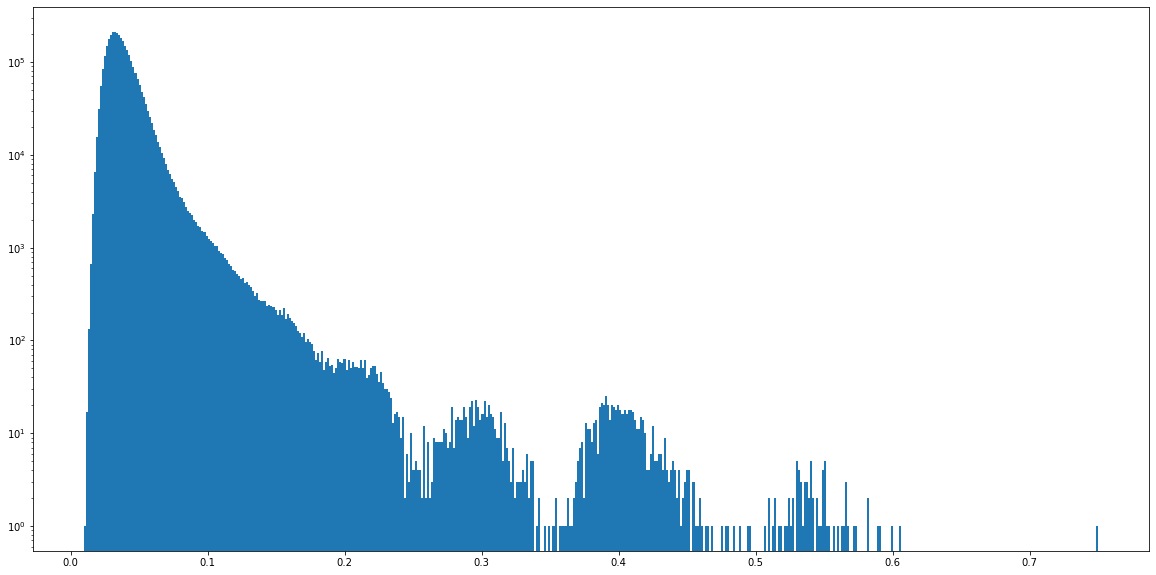

In [8]:
# Create histogram of cosine distances between all document pairs
# This helps in setting a threshold for identifying candidate document pairs

temp_array = data.toarray()
temp_array = np.triu(temp_array, k=1)
temp_array_elements = temp_array.flatten()
temp_array_elements = temp_array_elements[temp_array_elements > 0]

_ = plt.hist(temp_array_elements, bins=500)  # arguments are passed to np.histogram
plt.yscale('log')
#plt.savefig("faker")
plt.show()

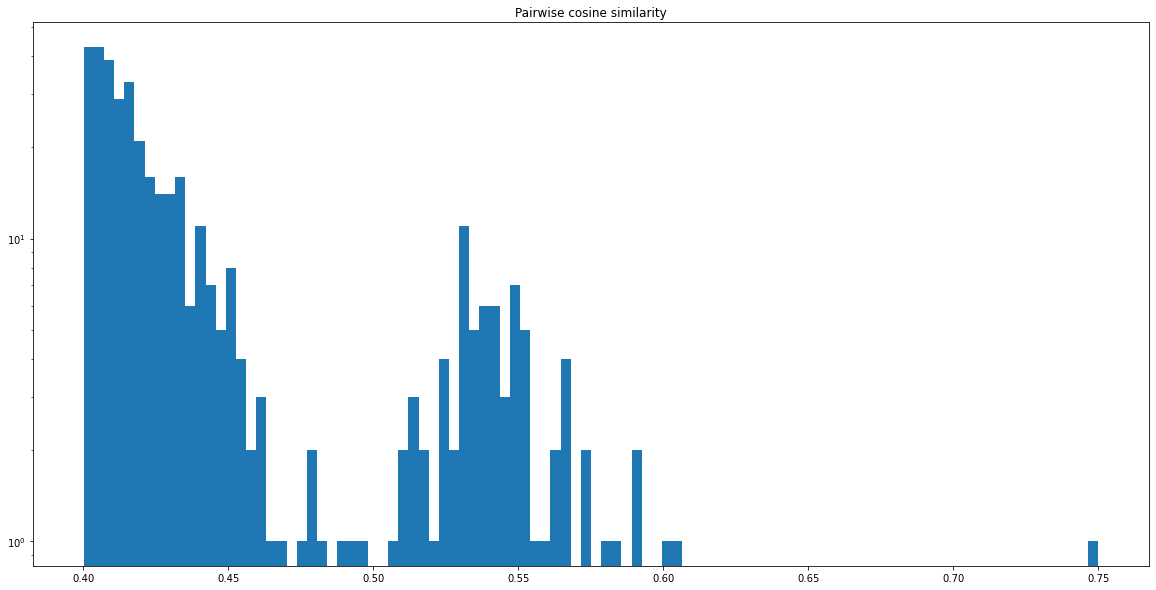

In [9]:
threshold = 0.4
_ = plt.hist(temp_array_elements[temp_array_elements > threshold], bins=100)
plt.title("Pairwise cosine similarity")
plt.yscale('log')
plt.show()

In [10]:
# Set a threshold, identify documents of interest
temp_array = data.toarray()
np.fill_diagonal(temp_array, 0)
fakes = np.argwhere(temp_array >= threshold)

fake_items = []
for item in fakes:
    fake_items.append(item[0])
    
fake_items = sorted(set(fake_items))

print(f"{len(fake_items)//2} potential documents of interest were discovered\n")

fake_count = 0
for fake_item in fake_items:
    if files[fake_item][-6:] == '_2.txt':
        fake_count += 1
        print(files[fake_item])
print(f"\n{fake_count} of these documents were correct")

36 potential documents of interest were discovered

Alan_Bell-6-1380-3963_2.txt
Alexandra_Turner-8-1759-4090_2.txt
Alyssa_Welch-2-2236-0718_2.txt
Bianca_Cobb-1-2842-1993_2.txt
Bradley_Johnson-2-4763-9635_2.txt
Brooke_Mcfarland-4-5891-9335_2.txt
Carlos_Wong-1-8298-5922_2.txt
Chelsea_Cobb-4-9518-0841_2.txt
Cynthia_Murray-1-1683-7547_2.txt
Daniel_King-5-0701-0049 _2.txt
Darrell_Perkins_MD-6-3740-7487_2.txt
Elizabeth_Williams-2-4416-5310_2.txt
Frank_Gordon-1-4199-6510_2.txt
George_Fleming-8-7663-9881_2.txt
Heather_Carter-5-1444-7942_2.txt

15 of these documents were correct


# Pepco analysis

In [11]:
# data is list of docs as strings
text_dir = "../data/final_data/pepco_bills/"
files = [file for file in os.listdir(text_dir) if file[-4:] == ".txt"]
print(f"There are {len(files)} files")

There are 2515 files


In [12]:
# count number of 'scam' docs
scam_counter = 0
for file in files:
    if (
        (file[-5:] == 'A.txt')
        | (file[-5:] == 'B.txt')
        | (file[-5:] == 'C.txt')
        | (file[-5:] == 'D.txt')
        | (file[-5:] == 'E.txt')
        | (file[-5:] == 'F.txt')
    ):
        scam_counter += 1
print(f"There are {scam_counter} fraudulent docs")

There are 15 fraudulent docs


In [13]:
# Load documents
text = []
for file in files:
    # ingest single text file
    with open(f"{text_dir}/{file}") as f:
        doc_text = f.read()
        text.append(doc_text)

In [14]:
# Vectorize documents
vectorizer = TfidfVectorizer(norm='l2', max_df=0.99)
X = vectorizer.fit_transform(text)

In [15]:
# Create doc adjacency matrix - equivalent to Cosine similarity when using l2 norm in TfidfVectorizer
data = X.dot(X.transpose())
print(f"document adjacency matrix shape: {data.shape}")

document adjacency matrix shape: (2515, 2515)


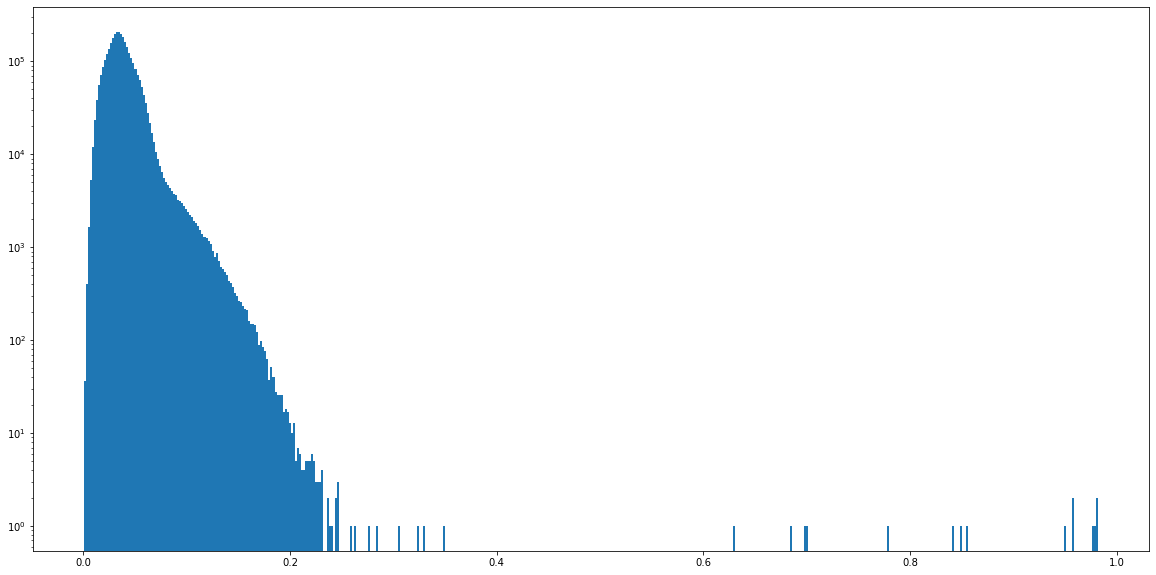

In [16]:
# Create histogram of cosine distances between all document pairs
# This helps in setting a threshold for identifying candidate document pairs

temp_array = data.toarray()
temp_array = np.triu(temp_array, k=1)
temp_array_elements = temp_array.flatten()
temp_array_elements = temp_array_elements[temp_array_elements > 0]

_ = plt.hist(temp_array_elements, bins=500)  # arguments are passed to np.histogram
plt.yscale('log')
#plt.savefig("pepco")
plt.show()

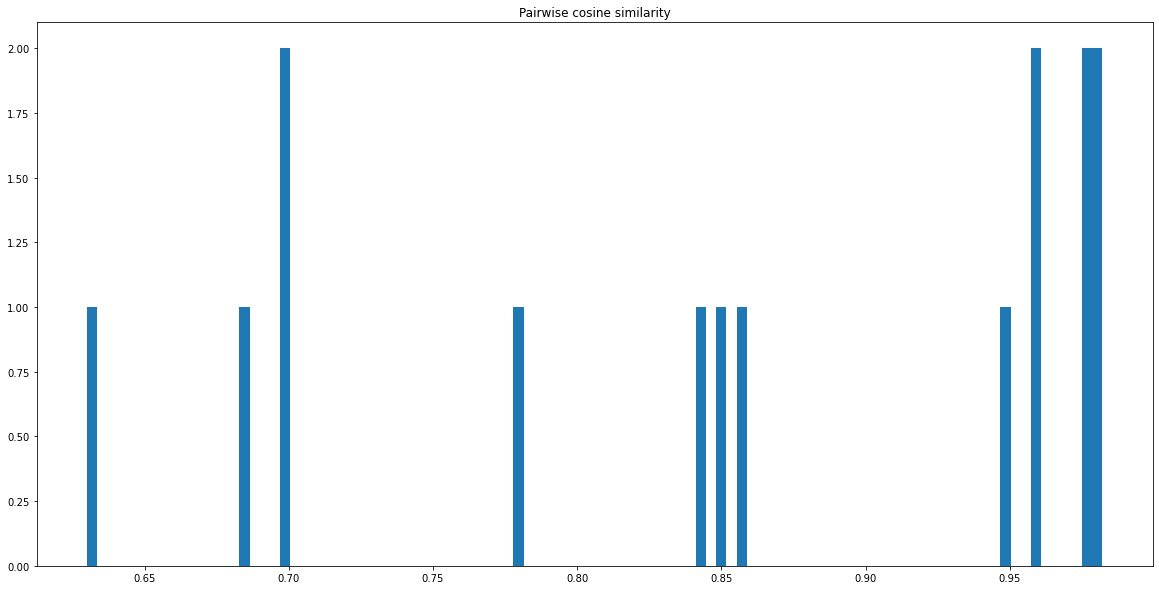

In [17]:
threshold = 0.6
_ = plt.hist(temp_array_elements[temp_array_elements > threshold], bins=100)
plt.title("Pairwise cosine similarity")
#plt.yscale('log')
plt.show()

In [18]:
# Set a threshold, identify documents of interest
temp_array = data.toarray()
np.fill_diagonal(temp_array, 0)
fakes = np.argwhere(temp_array >= threshold)

fake_items = []
for item in fakes:
    fake_items.append(item[0])
    
fake_items = sorted(set(fake_items))

print(f"{len(fake_items)//2} potential documents of interest were discovered\n")

fake_count = 0
for fake_item in fake_items:
    if (
        (files[fake_item][-5:] == 'A.txt')
        | (files[fake_item][-5:] == 'B.txt')
        | (files[fake_item][-5:] == 'C.txt')
        | (files[fake_item][-5:] == 'D.txt')
        | (files[fake_item][-5:] == 'E.txt')
        | (files[fake_item][-5:] == 'F.txt')
    ):
        fake_count += 1
        print(files[fake_item])
print(f"\n{fake_count} of these documents were correct")

15 potential documents of interest were discovered

Aaron_Wright-9-8329-8038_A.txt
Kristen_Sanchez-5-6336-6998_F.txt
Mark_Carter-3-1186-5497_B.txt
Mary_Robertson-2-6431-6188_F.txt
Michael_James-3-2217-0141_C.txt
Mr._Lance_Sullivan-8-0737-2346_F.txt
Phillip_Turner-7-0222-2716_D.txt
Renee_Sanchez-8-7432-1741_F.txt
Stacey_Smith-3-0393-2895_D.txt
Stephanie_Pham-5-2033-3910_C.txt
Tammy_Dillon-6-7389-3421_E.txt
Victoria_Cole-6-8186-1770_E.txt
William_Bryant-4-6878-9934_B.txt
William_Curry-2-0708-4364_F.txt
Zachary_Brady-3-0628-5093_A.txt

15 of these documents were correct
